In [1]:
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.signal import hilbert

matplotlib.style.use('ggplot')


# Check wihic computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name
if  comp_name == 'chim':
    #sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join(os.path.abspath('W:') , "earneodo", "bci_zf")
elif  'lookfar' in comp_name:
    sys.path.append('/Users/zeke/repos/ephysflow')
    sys.path.append('/Users/zeke/repos/soundflow/sound_tools')
    experiment_folder = os.path.join(os.path.abspath('/Volumes') , 'gentner', 'earneodo', 'bci_zf')

elif 'lintu' in comp_name:
    sys.path.append('/mnt/cube/earneodo/repos/soundflow/sound_tools')
    sys.path.append('/mnt/cube/earneodo/repos/ephysflow')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

elif 'passaro' in comp_name:
    sys.path.append('/mnt/cube/earneodo/repos/soundflow/sound_tools')
    sys.path.append('/mnt/cube/earneodo/repos/ephysflow')
    sys.path.append('/mnt/cube/earneodo/repos/analysis-tools')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')
    
raw_data_folder = os.path.join(experiment_folder, 'raw_data')
ss_data_folder = os.path.join(experiment_folder, 'ss_data')



Computer: passaro


In [2]:
#file structure
bird_id = 'z000'
sess = '2016-05-20_16-34-35'
rec = 'a'
run = 10
processor = '108'

raw_file_folder = os.path.join(raw_data_folder, bird_id, sess)
raw_file_base_name = 'experiment' + str(run)

raw_file_name = raw_file_base_name + '_' + processor + '.raw.kwd'
evt_file_name = raw_file_base_name + '.kwe'

raw_file_path = os.path.join(raw_file_folder, raw_file_name)
evt_file_path = os.path.join(raw_file_folder, evt_file_name)

# open the file in read mode
raw_file = h5py.File(raw_file_path, 'r')
evt_file = h5py.File(evt_file_path, 'r')

# load it with the open-ephys api for version 2 of kiwk format
import Kwik as oe
oe_file = oe.load(raw_file_path)


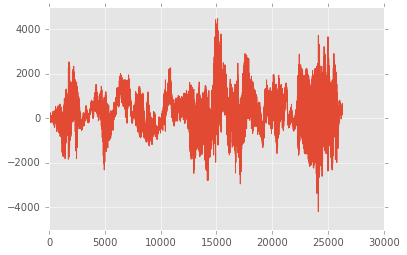

In [10]:
# grab a bout
import soundtools as st
chan_name = "CH34"
chan_number = 34
chan_sf = oe.get_sample_rate(raw_file)
chan_sound = st.DatSound(oe_file['data'][:,chan_number], chan_sf)
bout_start_s = 945.863993
bout_end_s = 946.740046

bout_start = int(bout_start_s*chan_sf)
bout_end = int(bout_end_s*chan_sf)
bout = st.Chunk(chan_sound, segment = [bout_start, bout_end])
plt.plot(bout.data)

In [4]:
#given a chunk that contains a sine wave, find its onset
def peaks(signal, min_height=0):
    np.where(signal[1:-1]>min_height)
    peak_ind = [i for i in np.where(signal[1:-1]>min_height)[0] if signal[i]>signal[i-1] & signal[i]>signal[i+1]]
    return peak_ind

def find_onset_sine(chunk, freq=1000, f_s=30000):
    roof = int(max(chunk)*0.25)
    first_peak = peaks(chunk, min_height=roof)[0]
    
    onset = first_peak - int(f_s/(4.*freq))
    return onset

# A filter
s_f = chan_sound.s_f
#The band where we expect most of the energy of zf song to be in
filt_lo = 10000 #Hz
filt_hi = 500 #Hz
hp_b, hp_a = sg.butter(4, filt_hi/(s_f/2.), btype='high')
lp_b, lp_a = sg.butter(4, filt_lo/(s_f/2.), btype='low')
def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt

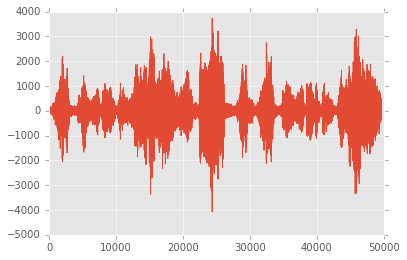

In [5]:
bout.apply_filter(band_pass_filter, hp_b, hp_a, lp_b, lp_a)
plt.plot(bout.data)

In [6]:
# Now try to save a channel as a wav file
from scipy.io import wavfile
out_file_name = raw_file_base_name +  '_' + chan_name + 'bout_filter.wav'
wavfile.write(os.path.join(raw_file_folder, out_file_name), bout.sound.s_f, np.array(bout.data, dtype='int16'))

In [8]:
ttl_number = 0
ttl_sf = oe.get_sample_rate(evt_file)
ttl_offset = oe.get_experiment_start_time(evt_file_path, time_in_samples=True)
oe.get_rising_edge_times(evt_file_path, ttl_number, time_in_samples=True)
oe.get_falling_edge_times(evt_file_path, ttl_number, time_in_samples=True)

array([], dtype=uint64)

93549


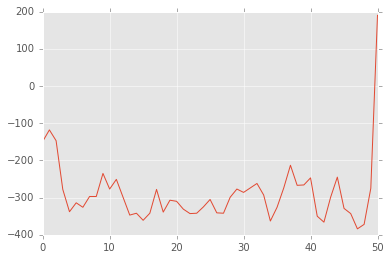

In [13]:
trial_number = 0

trial_begin = oe.get_rising_edge_times(evt_file_path, ttl_number, time_in_samples=True)[trial_number] - ttl_offset
trial_end = oe.get_falling_edge_times(evt_file_path, ttl_number, time_in_samples=True)[trial_number] - ttl_offset

trial_len = trial_end - trial_begin
print trial_len
chunk = chan_sound.stream[int(trial_begin):int(trial_end)]
onset = find_onset_sine(chunk)

plt.plot(chunk[onset-50:onset+1])

In [11]:
# Now try to save a channel as a wav file
from scipy.io import wavfile
out_file_name = raw_file_base_name +  '_' + chan_name + '.wav'
wavfile.write(os.path.join(raw_file_folder, out_file_name), chan_sound.s_f, chan_sound.stream)

In [6]:
# neural data
neural_chans = np.arange(0,32)
neural_sf = oe.get_sample_rate(raw_file)
neural_sound = st.DatSound(oe_file['data'][:,neural_chans], chan_sf)

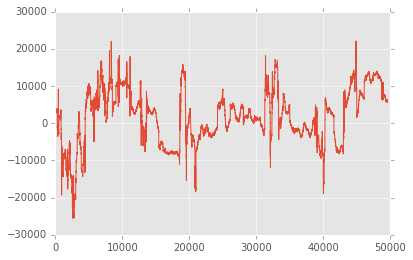

In [7]:
s_f = chan_sound.s_f
#The band where we expect most of the energy of zf song to be in
filt_lo = 15000 #Hz
filt_hi = 200 #Hz
hp_bn, hp_an = sg.butter(4, filt_hi/(s_f/2.), btype='high')
lp_bn, lp_an = sg.butter(4, filt_lo/(s_f/2.), btype='low')

frame = st.Chunk(neural_sound, chan_list=neural_chans, segment=[bout_start, bout_end])
frame.apply_filter(band_pass_filter, hp_bn, hp_an, lp_bn, lp_an)
plt.plot(frame.data[:,28])

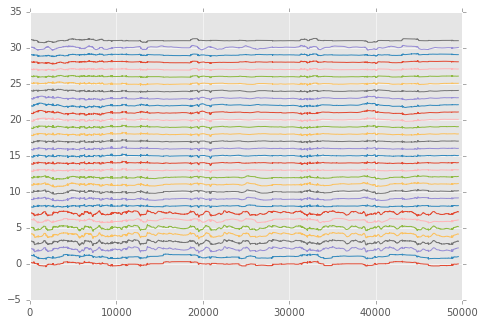

In [9]:
frame.plot();

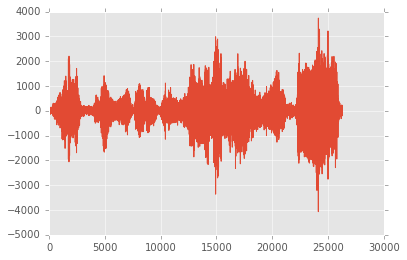

In [17]:
# compare two chunks
bout2_start_s = 948.042585
bout2_end_s = 949.312731

bout2_start = int(bout_start_s*chan_sf)
bout2_end = bout2_start + bout.samples
bout2 = st.Chunk(chan_sound, segment = [bout2_start, bout2_end])
bout2.apply_filter(band_pass_filter, hp_b, hp_a, lp_b, lp_a)
plt.plot(bout2.data)

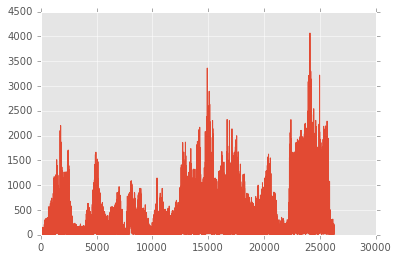

In [18]:
plt.plot(np.abs(bout2.data))

In [33]:
def envelope(data, window=100):
    analytic_signal = hilbert(data)
    amplitude_envelope = np.abs(analytic_signal)
    w=np.ones(300, 'd')
    return np.convolve(w/w.sum(),amplitude_envelope,mode='valid')

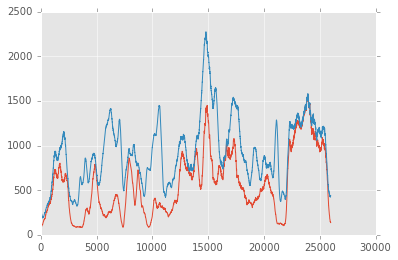

In [34]:
plt.plot(envelope(bout2.data))
plt.plot(envelope(bout.data))